C:\Users\szhang\AppData\Local\Temp\ipykernel_34172\2331965303.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  employee_counts = data_exploded.groupby(['Week Day', 'Time'])['Shift Count'].sum().reset_index()


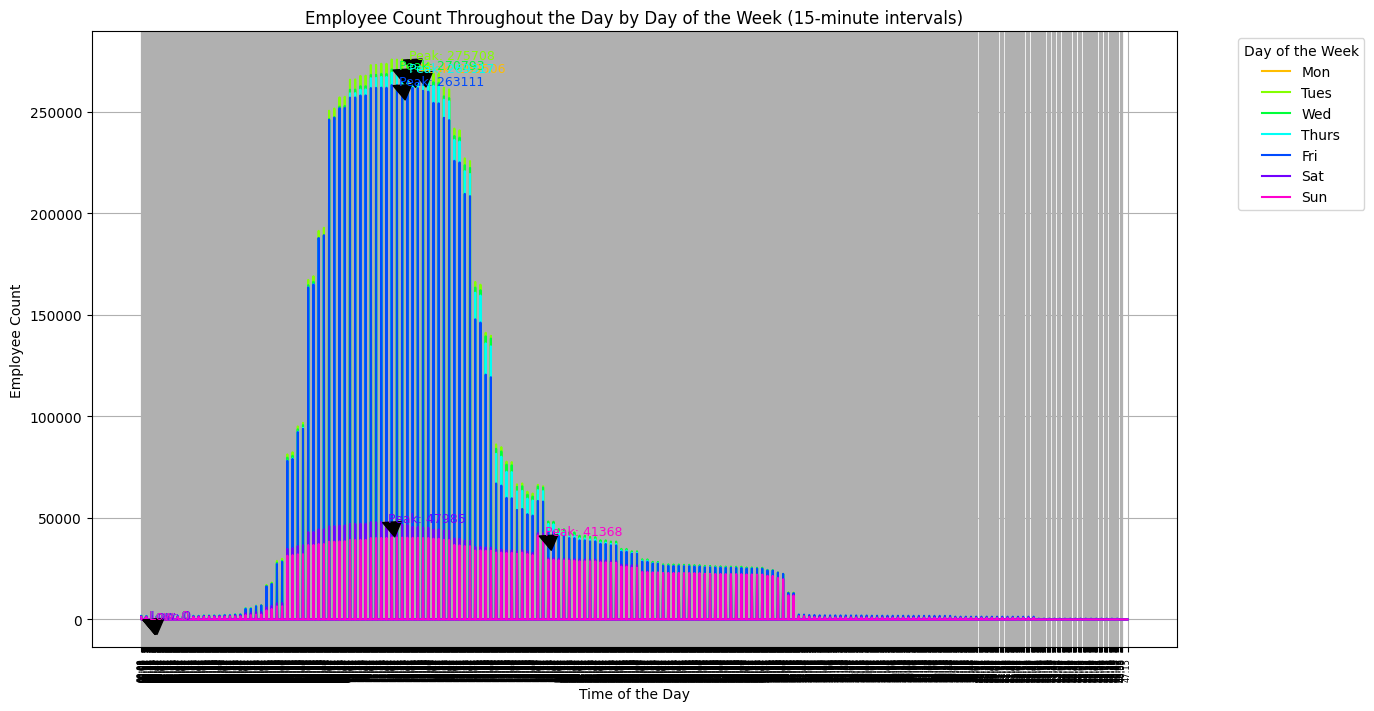

                   Peak  Low
Day of the Week             
Mon              269506    0
Tues             275708    0
Wed              270793    0
Thurs            269317    0
Fri              263111    0
Sat               47985    0
Sun               41368    0


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the file
file_path = r'C:\\Users\\szhang\\Downloads\\test NYU.csv'
file_path = r"C:\\Users\\szhang\\Downloads\\00001_12876_Dept-Shift-Counts_v1.0_11-13-2019 1_rs.csv"
data = pd.read_csv(file_path, delimiter=',', skipinitialspace=True)

# Drop unnecessary columns
data = data.drop(columns=['Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'LINE'])

# Function to convert time string to minutes since midnight
def time_to_minutes(time_str):
    try:
        hour, minute = map(int, time_str.split(':'))
        return hour * 60 + minute
    except ValueError:
        return None

# Function to create time intervals from shift period
def create_time_intervals(shift_period):
    try:
        start_time, end_time = str(shift_period).split('-')
        start_minutes = time_to_minutes(start_time)
        end_minutes = time_to_minutes(end_time)
        if end_minutes <= start_minutes:  # Handle overnight shifts
            end_minutes += 24 * 60
        intervals = list(range(start_minutes, end_minutes, 15))
        return intervals
    except ValueError:
        return []

# Apply the function to create time intervals
data['Time Intervals'] = data['Shift Period'].apply(create_time_intervals)

# Explode the DataFrame so each interval is a separate row
data_exploded = data.explode('Time Intervals')

# Remove rows with invalid intervals
data_exploded = data_exploded.dropna(subset=['Time Intervals'])

# Rename the 'Time Intervals' column to 'Time' for clarity
data_exploded = data_exploded.rename(columns={'Time Intervals': 'Time'})

# Convert 'Time' to integer type
data_exploded['Time'] = data_exploded['Time'].astype(int)

# Define a custom sorting order for weekdays
weekday_order = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
data_exploded['Week Day'] = pd.Categorical(data_exploded['Week Day'], categories=weekday_order, ordered=True)

# Group by 'Week Day' and 'Time' to sum the 'Shift Count'
employee_counts = data_exploded.groupby(['Week Day', 'Time'])['Shift Count'].sum().reset_index()

# Initialize peak and low value storage
peak_values = []
low_values = []

# Plot settings
plt.figure(figsize=(14, 8))
colors = sns.color_palette("hsv", len(weekday_order))

# Alternate background color for every whole hour
for hour in range(0, 24):
    plt.axvspan(hour * 60, (hour + 1) * 60, color='lightgrey' if hour % 2 == 0 else 'white', alpha=0.5)

# Plot each day with a unique color and annotate peak and low points
for i, day in enumerate(weekday_order):
    day_data = employee_counts[employee_counts['Week Day'] == day]
    if not day_data.empty:
        plt.plot(day_data['Time'], day_data['Shift Count'], label=day, color=colors[i])
        
        # Annotate peak point
        peak_idx = day_data['Shift Count'].idxmax()
        peak = day_data.loc[peak_idx]
        peak_values.append(peak['Shift Count'])
        plt.annotate(f'Peak: {peak["Shift Count"]}', 
                     xy=(peak['Time'], peak['Shift Count']), 
                     xytext=(peak['Time'] + 20, peak['Shift Count'] + 1),
                     arrowprops=dict(facecolor='black', shrink=0.2),  # Reduce arrow head size
                     fontsize=9,
                     color=colors[i])
        
        # Annotate low point
        low_idx = day_data['Shift Count'].idxmin()
        low = day_data.loc[low_idx]
        low_values.append(low['Shift Count'])
        plt.annotate(f'Low: {low["Shift Count"]}', 
                     xy=(low['Time'], low['Shift Count']), 
                     xytext=(low['Time'] + 20, low['Shift Count'] - 1),
                     arrowprops=dict(facecolor='black', shrink=0.2),  # Reduce arrow head size
                     fontsize=9,
                     color=colors[i])

# Convert time in minutes back to HH:MM format for x-axis labels
time_labels = [f'{int(t//60):02d}:{int(t%60):02d}' for t in employee_counts['Time'].unique()]
plt.xticks(employee_counts['Time'].unique(), time_labels, rotation=90, fontsize=6)  # Reduce font size to 50%

# Add titles and labels
plt.title('Employee Count Throughout the Day by Day of the Week (15-minute intervals)')
plt.xlabel('Time of the Day')
plt.ylabel('Employee Count')
plt.legend(title='Day of the Week', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Show plot
plt.show()

# Create a table with peak and low values
summary_table = pd.DataFrame({
    'Day of the Week': weekday_order,
    'Peak': peak_values,
    'Low': low_values
}).set_index('Day of the Week')

print(summary_table)
